# 🌍 Qartezator: Yet another aerial image-to-map translator

First you need to install qartezator from project root directory

In [1]:
!git clone https://github.com/AndranikSargsyan/qartezator.git

Cloning into 'qartezator'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 184 (delta 66), reused 160 (delta 46), pack-reused 0
Receiving objects: 100% (184/184), 1.29 MiB | 4.39 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [ ]:
!gdown https://drive.google.com/uc?id=1nq4yAQ5HSVOGL5B2juPU_L5WElKKVBPj
!unzip data.zip;

In [ ]:
!pip install pytorch_lightning

In [ ]:
import albumentations as A
import cv2
import numpy as np
import pytorch_lightning as pl
import random
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from albumentations.pytorch import ToTensorV2
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from typing import Union, Tuple, Optional, List

TransformType = Union[A.BasicTransform, A.BaseCompose]
DatasetElement = Union[np.ndarray, torch.Tensor]

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
ADDITIONAL_TARGETS = {'target': 'image'}


def load_image(path: Union[str, Path] = None) -> np.ndarray:
    """Loads RGB image.
    Args:
        path (Union[str, Path]): Path to image.
    Returns:
        np.ndarray.
    """
    image = cv2.imread(str(path))
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def seed_worker(worker_id):
    """Seeds Dataloader worker"""
    worker_seed = np.random.get_state()[1][0] + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def ceil_modulo(x, mod):
    if x % mod == 0:
        return x
    return (x // mod + 1) * mod


def pad_img_to_modulo(img, mod):
    height, width, channels = img.shape
    out_height = ceil_modulo(height, mod)
    out_width = ceil_modulo(width, mod)
    return np.pad(img, ((0, out_height - height), (0, out_width - width), (0, 0)), mode='symmetric')

In [2]:
class QartezatorDataset(Dataset):
    def __init__(
        self,
        root_path: Union[str, Path],
        split_file_path: Union[str, Path],
        source_transform: Optional[TransformType] = None,
        common_transform: Optional[TransformType] = None,
        pad_to_modulo: int = 32
    ):
        self.root_path = Path(root_path)
        self.split_file_path = split_file_path
        self.source_transform = source_transform
        self.common_transform = common_transform
        self.pad_to_modulo = pad_to_modulo
        with open(split_file_path) as f:
            self.img_paths = f.read().splitlines()

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index: int) -> Tuple[DatasetElement, DatasetElement]:
        img_path = self.root_path / self.img_paths[index]
        img = load_image(img_path)
        img_h, img_w = img.shape[:2]
        source_img = img[:, :img_w//2]
        target_img = img[:, img_w//2:]
        if self.pad_to_modulo > 0:
            source_img = pad_img_to_modulo(source_img, self.pad_to_modulo)
            target_img = pad_img_to_modulo(target_img, self.pad_to_modulo)
        if self.source_transform is not None:
            transformed = self.source_transform(image=source_img)
            source_img = transformed['image']
        if self.common_transform is not None:
            transformed = self.common_transform(image=source_img, target=target_img)
            source_img = transformed['image']
            target_img = transformed['target']
        source_img = source_img / 255.0
        target_img = target_img / 255.0
        return source_img, target_img

In [3]:
def get_common_augmentations(crop_size=256):
    transforms = A.Compose([
        A.Rotate(limit=180, border_mode=cv2.BORDER_REFLECT),
        A.RandomScale(scale_limit=(0.6, 1.4)),
        A.RandomCrop(height=crop_size, width=crop_size, always_apply=True)
    ], additional_targets=ADDITIONAL_TARGETS)
    return transforms

def get_source_augmentations():
    transforms = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05),
        A.OneOf([
            A.CLAHE(),
            A.Sharpen(),
            A.Blur(),
        ], p=0.5),
        A.OneOf([
            A.RGBShift(),
            A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=30, val_shift_limit=5, p=0.5),
        ]),
        A.ISONoise(p=0.5)
    ])
    return transforms

def get_transforms(
    mean: List[float] = None,
    std: List[float] = None,
    augmentations: TransformType = None
) -> TransformType:
    """Creates default base transform.
    Args:
        mean (List[float]): List of means for normalization.
        std (List[float]): List of stds for normalization.
        augmentations (TransformType): Augmentations to use.
    Returns:
        TransformType
    """
    transforms_list = []
    if augmentations is not None:
        transforms_list.append(augmentations)
    if mean is not None and std is not None:
        transforms_list.append(A.Normalize(mean=mean, std=std))
    transforms_list.append(ToTensorV2())
    transform = A.Compose(transforms_list, additional_targets=ADDITIONAL_TARGETS)
    return transform


In [4]:
class QartezatorDataModule(pl.LightningDataModule):

    def __init__(
        self,
        root_path: Union[Path, str],
        train_txt_path: Union[Path, str],
        val_txt_path: Union[Path, str],
        test_txt_path: Union[Path, str],
        train_batch_size: int = 32,
        val_batch_size: int = 6,
        test_batch_size: int = 32,
        num_workers: int = 4,
        input_size: int = 256,
        pad_to_modulo: int = 32,
        common_transform: Optional[TransformType] = None,
        source_transform: Optional[TransformType] = None,
        mean: List[float] = None,
        std: List[float] = None
    ) -> None:
        super().__init__()

        self.root_path = root_path
        self.train_txt_path = train_txt_path
        self.val_txt_path = val_txt_path
        self.test_txt_path = test_txt_path
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.test_batch_size = test_batch_size
        self.num_workers = num_workers
        self.input_size = input_size
        self.pad_to_modulo = pad_to_modulo
        self.common_transform = common_transform
        self.source_transform = source_transform
        self.mean = mean
        self.std = std

    def train_dataloader(self) -> DataLoader:
        # source_augmentations = ...

        common_transform = self.common_transform
        if self.common_transform is None:
            common_augmentations = get_common_augmentations(self.input_size)
            common_transform = get_transforms(mean=self.mean, std=self.std, augmentations=common_augmentations)

        dataset = QartezatorDataset(
            root_path=self.root_path,
            split_file_path=self.train_txt_path,
            source_transform=self.source_transform,
            common_transform=common_transform,
            pad_to_modulo=self.pad_to_modulo
        )

        return DataLoader(
            dataset,
            batch_size=self.train_batch_size,
            num_workers=self.num_workers,
            drop_last=True,
            shuffle=True,
            pin_memory=True,
            worker_init_fn=seed_worker
        )

    def val_dataloader(self) -> DataLoader:
        transform = get_transforms(mean=self.mean, std=self.std)

        dataset = QartezatorDataset(
            root_path=self.root_path,
            split_file_path=self.val_txt_path,
            common_transform=transform,
            pad_to_modulo=self.pad_to_modulo
        )

        return DataLoader(
            dataset,
            batch_size=self.val_batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True
        )

    def test_dataloader(self, *args, **kwargs) -> DataLoader:
        transform = get_transforms(mean=self.mean, std=self.std)

        dataset = QartezatorDataset(
            root_path=self.root_path,
            split_file_path=self.test_txt_path,
            common_transform=transform,
            pad_to_modulo=self.pad_to_modulo
        )

        return DataLoader(
            dataset,
            batch_size=self.val_batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True
        )

## Setup Dataloaders

In [5]:
root_path =  './data/maps'
train_txt_path = './assets/train.txt'
val_txt_path = './assets/val.txt'
test_txt_path = './assets/test.txt'

In [9]:
ds = QartezatorDataset(
    root_path=root_path,
    split_file_path=train_txt_path,
    common_transform=get_common_augmentations(256)
)
sample_source_img, sample_target_img = ds[42]

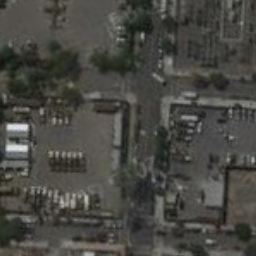

In [10]:
Image.fromarray((sample_source_img*255).astype(np.uint8))

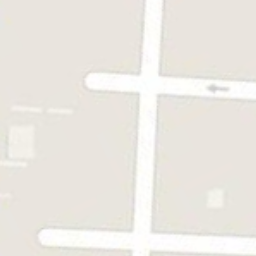

In [11]:

Image.fromarray((sample_target_img*255).astype(np.uint8))

In [13]:
dm = QartezatorDataModule(
    root_path=root_path,
    train_txt_path=train_txt_path,
    val_txt_path=val_txt_path,
    test_txt_path=test_txt_path,
    train_batch_size=16,
    val_batch_size=4,
    input_size=256
)
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()
test_dataloader = dm.test_dataloader()

In [14]:
for batch in train_dataloader:
    source, target = batch
    print(f'Source batch shape: {source.shape}')
    print(f'Target batch shape: {target.shape}\n')
    break

Source batch shape: torch.Size([16, 3, 256, 256])
Target batch shape: torch.Size([16, 3, 256, 256])



In [15]:
len(train_dataloader.dataset)

2792

In [16]:
len(val_dataloader.dataset)

250

In [17]:
len(test_dataloader.dataset)

250

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, out_channels, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.out_channels = out_channels
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
unet_model = UNet(3,3)
# unet_model.load_state_dict(torch.load('./notebooks/models/best_qartezator_unet_0.02188.pth'))
# Define loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.000001)


def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device = 'cuda'
):
    model.train()
    train_loss = 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} ")

    
def val_step(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    device = 'cuda'
):
    test_loss = 0
    model.to(device)
    model.eval()
    with torch.no_grad(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
        test_loss /= len(data_loader)
        print(f"Validation loss: {test_loss:.5f}\n")
    return test_loss

def train_model(model, model_name, loss_fn, optimizer, train_loader, val_loader, epochs=500, seed=0, scheduler=None, device='cuda'):
    best_val_loss = np.inf
    best_path = ''
    
    torch.manual_seed(seed)

    for epoch in range(epochs):
        print(f"Epoch: {epoch}\n---------")

        train_step(data_loader=train_loader, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        
        if scheduler is not None:
            scheduler.step()
 
        val_loss = val_step(data_loader=val_loader,
            model=model,
            loss_fn=loss_fn,
            device=device
        )

        if epoch % 5 == 0:
            for source, target in val_dataloader:
                source = source.to(device)
                model.to(device)
                test_pred = model(source)
                test_pred = test_pred.detach().permute(0,2,3,1).clip(0, 1).cpu().numpy()
                grid = []
                for i in range(len(test_pred)):
                    s = source[i].permute(1,2,0).detach().cpu().numpy()
                    s = (s * 255).astype(np.uint8)
                    t = target[i].permute(1,2,0).detach().cpu().numpy()
                    t = (t * 255).astype(np.uint8)
                    tp = test_pred[i]
                    tp = (tp * 255).astype(np.uint8)
                    grid.append(np.hstack([s, t, tp]))
                grid = np.vstack(grid)
                Image.fromarray(grid).save(f'./notebooks/samples/grid_{epoch}.png')
                break

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_path = f'./notebooks/models/best_{model_name}_{val_loss:.5f}.pth'
            print(f"Saving best {model_name} with val_loss={val_loss}")
            torch.save(obj=model.state_dict(), f=best_path)

                
        torch.save(obj=model.state_dict(), f=f'last_{model_name}.pth')
    
    return model.load_state_dict(torch.load(f=best_path))

    
train_model(unet_model, 'qartezator_unet', loss_fn, optimizer, train_dataloader, val_dataloader, epochs=1000)

Epoch: 0
---------
Train loss: 0.02418 
Validation loss: 0.02176

Saving best qartezator_unet with val_loss=0.02176208607852459
Epoch: 1
---------
Train loss: 0.02408 
Validation loss: 0.02170

Saving best qartezator_unet with val_loss=0.021704526618123055
Epoch: 2
---------
Train loss: 0.02329 
Validation loss: 0.02178

Epoch: 3
---------
Train loss: 0.02381 
Validation loss: 0.02170

Saving best qartezator_unet with val_loss=0.021699054166674614
Epoch: 4
---------
Train loss: 0.02370 
Validation loss: 0.02171

Epoch: 5
---------
Train loss: 0.02319 
Validation loss: 0.02172

Epoch: 6
---------
Train loss: 0.02354 
Validation loss: 0.02172

Epoch: 7
---------
Train loss: 0.02372 
Validation loss: 0.02170

Epoch: 8
---------
Train loss: 0.02337 
Validation loss: 0.02167

Saving best qartezator_unet with val_loss=0.02167453058063984
Epoch: 9
---------
Train loss: 0.02334 
Validation loss: 0.02171

Epoch: 10
---------
Train loss: 0.02369 
Validation loss: 0.02171

Epoch: 11
---------
Tra

Validation loss: 0.02154

Epoch: 107
---------
Train loss: 0.02336 
Validation loss: 0.02150

Epoch: 108
---------
Train loss: 0.02328 
Validation loss: 0.02151

Epoch: 109
---------
Train loss: 0.02299 
Validation loss: 0.02146

Saving best qartezator_unet with val_loss=0.02146441675722599
Epoch: 110
---------
Train loss: 0.02291 
Validation loss: 0.02149

Epoch: 111
---------
Train loss: 0.02309 
Validation loss: 0.02148

Epoch: 112
---------
Train loss: 0.02310 
Validation loss: 0.02150

Epoch: 113
---------
Train loss: 0.02324 
Validation loss: 0.02156

Epoch: 114
---------
Train loss: 0.02314 
Validation loss: 0.02151

Epoch: 115
---------
Train loss: 0.02286 
Validation loss: 0.02151

Epoch: 116
---------
Train loss: 0.02321 
Validation loss: 0.02151

Epoch: 117
---------
Train loss: 0.02325 
Validation loss: 0.02151

Epoch: 118
---------
Train loss: 0.02307 
Validation loss: 0.02151

Epoch: 119
---------
Train loss: 0.02349 
Validation loss: 0.02150

Epoch: 120
---------
Train l